In [1]:
!pip install torch
!pip install -U numpy

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.utils.np_utils import to_categorical

In [3]:
import matplotlib.pyplot as plt 
import torch.nn.functional as F 
import torch 
import numpy as np 

def show_image(image,label,get_denormalize = True):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
        
    else: 
        plt.imshow(image)
        plt.title(label)

def show_grid(image,title = None):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    image = np.clip(image,0,1)
    
    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title != None:
        plt.title(title)


def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


def view_classify(image,ps,label):
    
    class_name = ['cancer', 'normal']
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

In [4]:
class CFG:

  epochs =20                              # No. of epochs for training the model
  lr = 0.001                              # Learning rate
  batch_size = 16                         # Batch Size for Dataset

  model_name = 'tf_efficientnet_b4_ns'    # Model name (we are going to import model from timm)
  img_size = 224                          # Resize all the images to be 224 by 224

  # going to be used for loading dataset
  train_path='breast_cancer/train'
  validate_path='breast_cancer/val'
  test_path='breast_cancer/test'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))

On which device we are on:cpu


In [5]:
!pip install torchvision

In [6]:
from torchvision import transforms as T,datasets

In [7]:
train_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

validate_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

test_transform = T.Compose([
                             
                             T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
                             #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

In [8]:
trainset=datasets.ImageFolder(CFG.train_path,transform=train_transform)
print("Trainset Size:  {}".format(len(trainset)))

Trainset Size:  844


In [9]:
validateset=datasets.ImageFolder(CFG.validate_path,transform=validate_transform)
print("validateset Size:  {}".format(len(validateset)))

validateset Size:  226


In [10]:
testset=datasets.ImageFolder(CFG.test_path,transform=test_transform)
print("testset Size:  {}".format(len(testset)))

testset Size:  57


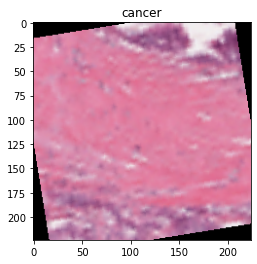

In [11]:
img,label = trainset[20]
#print(trainset.class_to_idx)

class_name =["cancer","normal"]
show_image(img,class_name[label])

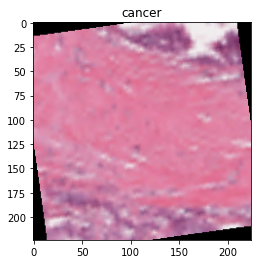

In [12]:
img,label = trainset[20]
#print(trainset.class_to_idx)

class_name =["cancer","normal"]
show_image(img,class_name[label]) 

# randomly rotated

In [13]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [14]:
trainloader = DataLoader(trainset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader))) #Trainset Size:  1127 / batch_size: 16 = 53(No. of batches in trainloader) 
print("No. of Total examples:{}".format(len(trainloader.dataset)))

No. of batches in trainloader:53
No. of Total examples:844


In [15]:
validationloader = DataLoader(validateset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader))) #validationset Size:  241/ batch_size: 16 = 15(No. of batches in validationloader) 
print("No. of Total examples:{}".format(len(validationloader.dataset)))

No. of batches in validationloader:15
No. of Total examples:226


In [16]:
testloader = DataLoader(testset,batch_size=CFG.batch_size,shuffle=True)
print("No. of batches in testloader:{}".format(len(testloader))) #testset Size:  61 / batch_size: 16 = 4(No. of batches in testloader) 
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in testloader:4
No. of Total examples:57


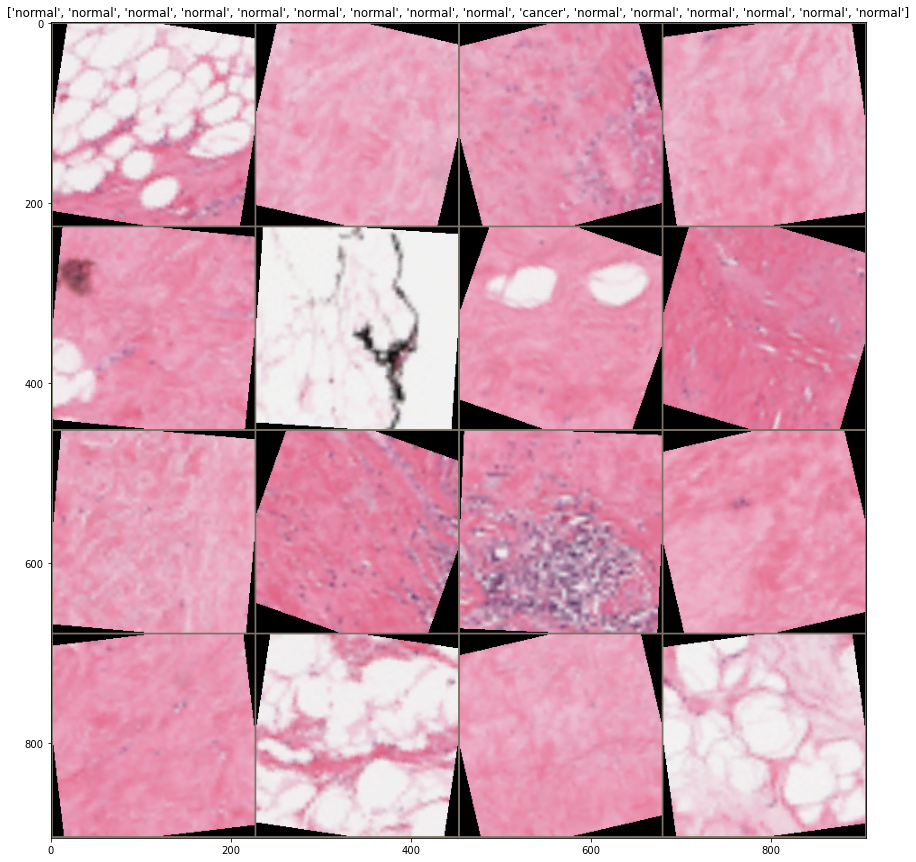

In [17]:
dataiter = iter(trainloader)
images,labels = dataiter.next()

out = make_grid(images,nrow=4)

show_grid(out,title = [class_name[x] for x in labels])

In [18]:
!pip install timm   
#install PyTorch Image Models

In [19]:
from torch import nn
import torch.nn.functional as F
import timm # PyTorch Image Models

model = timm.create_model(CFG.model_name,pretrained=True) #load pretrained model

In [20]:
model

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
     

In [21]:
#let's update the pretarined model:
for param in model.parameters():
  param.requires_grad=False

#orginally, it was:
#(classifier): Linear(in_features=1792, out_features=1000, bias=True)


#we are updating it as a 2-class classifier:
model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=625), #1792 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2), 
)

model

# after updatingnow it becomes:
#(classifier): Sequential(
#    (0): Linear(in_features=1792, out_features=625, bias=True)
#    (1): ReLU()
#    (2): Dropout(p=0.3, inplace=False)
#    (3): Linear(in_features=625, out_features=256, bias=True)
#    (4): ReLU()
#    (5): Linear(in_features=256, out_features=2, bias=True)
#  )

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
     

In [22]:
!pip install torchsummary

In [23]:
from torchsummary import  summary
model.to(device) # move the model to GPU
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1         [-1, 48, 112, 112]           1,296
       BatchNorm2d-2         [-1, 48, 112, 112]              96
              SiLU-3         [-1, 48, 112, 112]               0
            Conv2d-4         [-1, 48, 112, 112]             432
       BatchNorm2d-5         [-1, 48, 112, 112]              96
              SiLU-6         [-1, 48, 112, 112]               0
            Conv2d-7             [-1, 12, 1, 1]             588
              SiLU-8             [-1, 12, 1, 1]               0
            Conv2d-9             [-1, 48, 1, 1]             624
          Sigmoid-10             [-1, 48, 1, 1]               0
    SqueezeExcite-11         [-1, 48, 112, 112]               0
           Conv2d-12         [-1, 24, 112, 112]           1,152
      BatchNorm2d-13         [-1, 24, 112, 112]              48
         Identity-14         [-1, 24, 1

In [24]:
class cancerTrainer():
    
    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() # this turn on dropout
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) ###
            
            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) ###
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'ColabPneumoniaModel.pt')
                valid_min_loss = avg_valid_loss

                
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = CFG.lr)

trainer = cancerTrainer(criterion,optimizer)
history = trainer.fit(model,trainloader,validationloader,epochs = CFG.epochs)

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.12548728700106343
Epoch : 1 Train Loss : 0.144562 Train Acc : 0.938679
Epoch : 1 Valid Loss : 0.125487 Valid Acc : 0.945833


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.110185 Train Acc : 0.948899
Epoch : 2 Valid Loss : 0.221509 Valid Acc : 0.920833


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Valid_loss decreased 0.12548728700106343 --> 0.12230015595268924
Epoch : 3 Train Loss : 0.098069 Train Acc : 0.959513
Epoch : 3 Valid Loss : 0.122300 Valid Acc : 0.950000


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.124700 Train Acc : 0.950079
Epoch : 4 Valid Loss : 0.134249 Valid Acc : 0.937500


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.123615 Train Acc : 0.945362
Epoch : 5 Valid Loss : 0.190268 Valid Acc : 0.895833


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Valid_loss decreased 0.12230015595268924 --> 0.11575116350625952
Epoch : 6 Train Loss : 0.096846 Train Acc : 0.961085
Epoch : 6 Valid Loss : 0.115751 Valid Acc : 0.950000


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.095043 Train Acc : 0.964623
Epoch : 7 Valid Loss : 0.151513 Valid Acc : 0.941667


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.107176 Train Acc : 0.955189
Epoch : 8 Valid Loss : 0.193578 Valid Acc : 0.933333


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Valid_loss decreased 0.11575116350625952 --> 0.09649575880418221
Epoch : 9 Train Loss : 0.090311 Train Acc : 0.958726
Epoch : 9 Valid Loss : 0.096496 Valid Acc : 0.962500


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.073263 Train Acc : 0.964623
Epoch : 10 Valid Loss : 0.299114 Valid Acc : 0.933333


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Valid_loss decreased 0.09649575880418221 --> 0.09193051554999936
Epoch : 11 Train Loss : 0.094983 Train Acc : 0.963443
Epoch : 11 Valid Loss : 0.091931 Valid Acc : 0.945833


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch : 12 Train Loss : 0.089013 Train Acc : 0.961085
Epoch : 12 Valid Loss : 0.094368 Valid Acc : 0.958333


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.102836 Train Acc : 0.955975
Epoch : 13 Valid Loss : 0.108973 Valid Acc : 0.954167


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Valid_loss decreased 0.09193051554999936 --> 0.08795130713066707
Epoch : 14 Train Loss : 0.101564 Train Acc : 0.957940
Epoch : 14 Valid Loss : 0.087951 Valid Acc : 0.958333


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch : 15 Train Loss : 0.101296 Train Acc : 0.957154
Epoch : 15 Valid Loss : 0.126075 Valid Acc : 0.908333


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.082215 Train Acc : 0.959513
Epoch : 16 Valid Loss : 0.154726 Valid Acc : 0.950000


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.084962 Train Acc : 0.963050
Epoch : 17 Valid Loss : 0.119689 Valid Acc : 0.941667


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 0.067962 Train Acc : 0.970126
Epoch : 18 Valid Loss : 0.266118 Valid Acc : 0.916667


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.099778 Train Acc : 0.957154
Epoch : 19 Valid Loss : 0.092307 Valid Acc : 0.958333


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.067421 Train Acc : 0.969340
Epoch : 20 Valid Loss : 0.101287 Valid Acc : 0.975000


In [27]:
model.load_state_dict(torch.load('ColabPneumoniaModel.pt'))
model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(model,testloader)


print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

  0%|          | 0/4 [00:00<?, ?it/s]

Test Loss : 0.03267268871422857
Test Acc : 1.0


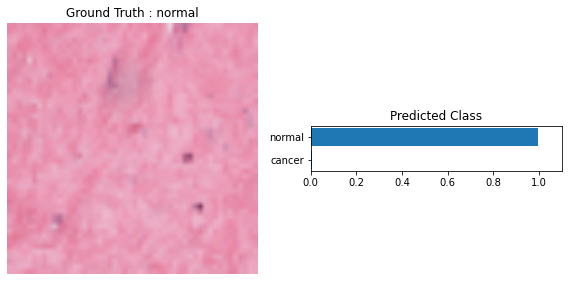

In [28]:
import torch.nn.functional as F

image,label = testset[15]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

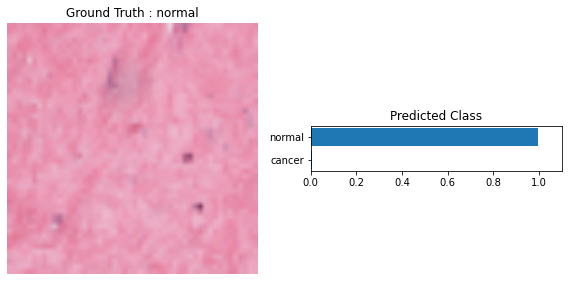

In [29]:
import torch.nn.functional as F

image,label = testset[15]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

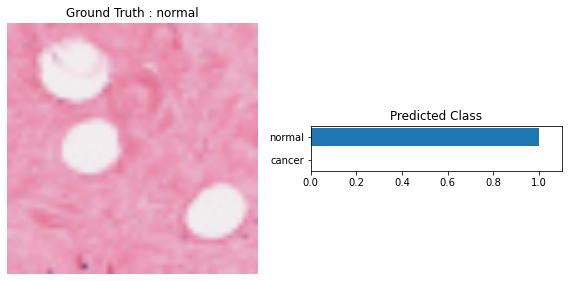

In [30]:
import torch.nn.functional as F

image,label = testset[55]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

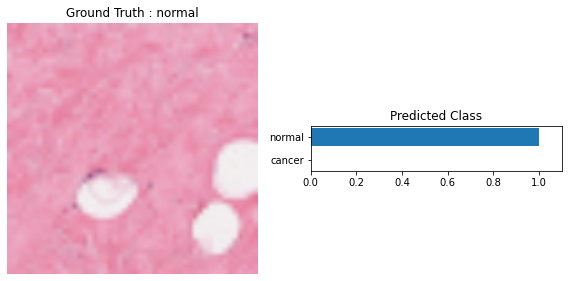

In [31]:
import torch.nn.functional as F

image,label = testset[10]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

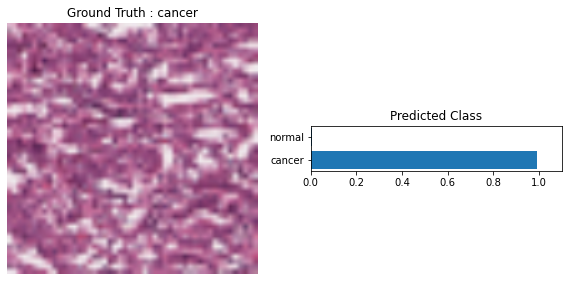

In [32]:
import torch.nn.functional as F

image,label = testset[1]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

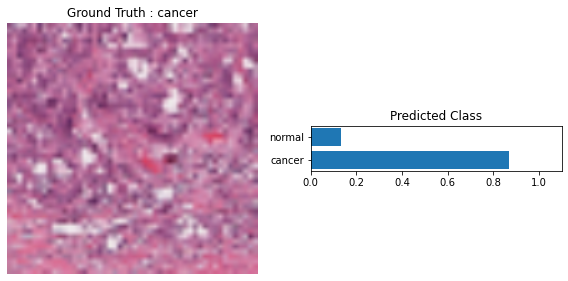

In [33]:
import torch.nn.functional as F

image,label = testset[3]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

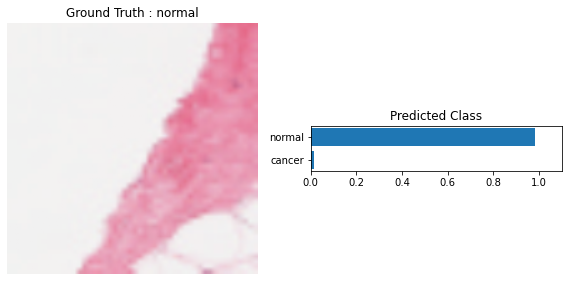

In [34]:
import torch.nn.functional as F

image,label = testset[6]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

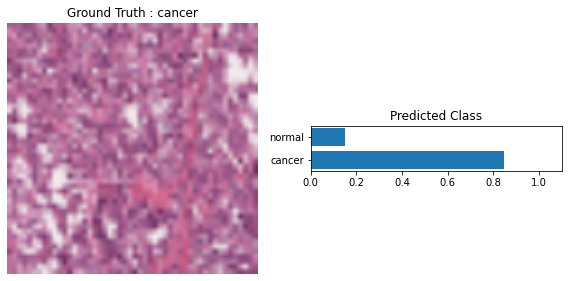

In [35]:
import torch.nn.functional as F

image,label = testset[5]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

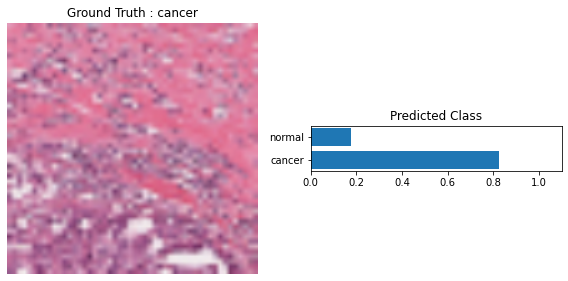

In [36]:
import torch.nn.functional as F

image,label = testset[0]

ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps,dim = 1)

view_classify(image,ps,label)

In [46]:
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

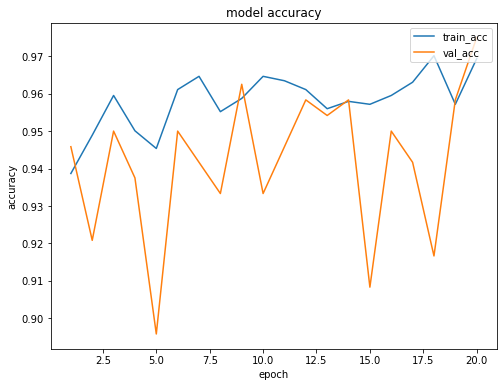

In [72]:
import matplotlib.pyplot as plt
#history =trainer.fit(train_x, train_y,validation_split = 0.1, epochs=20, batch_size=16)
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])

import matplotlib.pylab as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6))

Epoches=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
train_acc= [0.938679,0.948899, 0.959513, 0.950079,0.945362, 0.961085,0.964623, 0.955189,0.958726,0.964623,0.963443,0.961085,0.955975,0.957940,0.957154,0.959513,0.963050, 0.970126,0.957154,0.969340]
Epoches=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
val_acc= [0.945833,0.920833,0.950000,0.937500, 0.895833,0.950000,0.941667,0.933333,0.962500,0.933333,0.945833,0.958333,0.954167,0.958333,0.908333,0.950000,0.941667,0.916667,0.958333,0.975000]
plt.plot(Epoches,train_acc)
plt.plot(Epoches,val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper right')
plt.show()

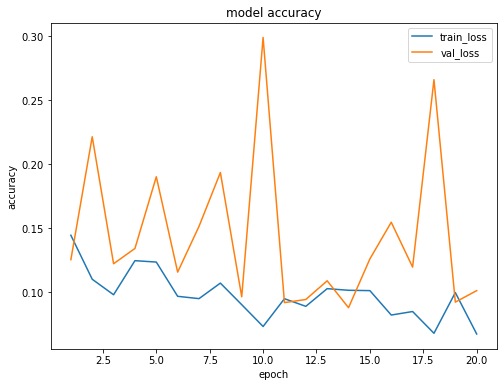

In [70]:
import matplotlib.pyplot as plt

import matplotlib.pylab as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6))

#history =trainer.fit(train_x, train_y,validation_split = 0.1, epochs=20, batch_size=16)
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
Epoches=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
train_loss= [0.144562,0.110185,0.098069,0.124700,0.123615,0.096846,0.095043,0.107176,0.090311,0.073263,0.094983,0.089013,0.102836,0.101564,0.101296,0.082215,0.084962,0.067962,0.099778,0.067421]
Epoches=Epoches=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
val_loss= [0.125487,0.221509,0.122300 ,0.134249, 0.190268,0.115751,0.151513,0.193578,0.096496,0.299114,0.091931,0.094368,0.108973,0.087951,0.126075,0.154726,0.119689,0.266118,0.092307,0.101287]
plt.plot(Epoches,train_loss)
plt.plot(Epoches,val_loss)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.show()